In [8]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import random

In [9]:
data = np.load('stats_8.npz', allow_pickle=True)
print('load complete')
data = data['stats'].item()

load complete


iou zero percentage:  0.45225073622212875


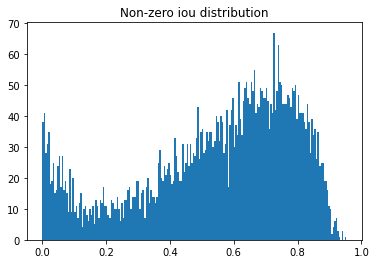

In [10]:
iou_nonzero = []
iou_total = []
for scene in data['iou_list'].keys():
    l = data['iou_list'][scene]
    l = [x for x in l if x > 0.0]
    iou_total.extend(data['iou_list'][scene])
    iou_nonzero.extend(l)
    
print("iou zero percentage: ", (len(iou_total)-len(iou_nonzero))/len(iou_total))
plt.hist(iou_nonzero, bins=200)
plt.title("Non-zero iou distribution")
plt.show()

In [11]:
def get_scenes(path):
    scenes = {}
    labels = json.load(open(path, 'r'))
    for label in labels:
        if label['scene_id'] not in scenes.keys():
            scenes[label['scene_id']] = []
        if label['object_id'] not in scenes[label['scene_id']]:
            scenes[label['scene_id']].append(label['object_id'])
            
    return scenes

def get_description(labels, scene, obj, ann):
    for label in labels:
        if label['scene_id'] == scene and label['object_id'] == obj and label['ann_id'] == ann:
            return label['description']
    return None

def get_label_name(path):
    df = pd.read_csv(path, sep='\t')
    label_name = {}
    for i in range(1, 41):
        for _, row in df.iterrows():
            if row['nyu40id'] == i:
                label_name[i] = row['nyu40class']
    return label_name
                
def cnt_to_rate(cnt_list):
    cnt_list = np.array(cnt_list)
    cnt_list = cnt_list / cnt_list.sum()
    return cnt_list

def get_pred_label(bbox_min, bbox_max, seed_points, seed_sem_labels, seed_ins_labels):
    ind = []
    for i, point in enumerate(seed_points):
        point = np.array(point)
        bbox_min = np.array(bbox_min)
        bbox_max = np.array(bbox_max)
        if (point > bbox_min).sum() == 3 and (point < bbox_max).sum() == 3:
            ind.append(i)
    bbox_sem_labels = seed_sem_labels[ind]
    bbox_sem_fore_labels = bbox_sem_labels[bbox_sem_labels >= 0]
    bbox_ins_labels = seed_ins_labels[ind]
    bbox_ins_fore_labels = bbox_ins_labels[bbox_ins_labels >= 0]
    sem_label_cnt = np.bincount(bbox_sem_fore_labels)
    ins_label_cnt = np.bincount(bbox_ins_fore_labels)
    if len(sem_label_cnt) == 0:
        return -2, -1
    return np.argmax(sem_label_cnt), np.argmax(ins_label_cnt)
    

def get_table_row(prefix, instance, label_name_dict, description_file):
    d = {}
    sem_labels = np.array(instance[f'{prefix}_sem_labels'])
    ins_labels = np.array(instance[f'{prefix}_ins_labels'])
    
    fg_sem_labels = []
    fg_ins_labels = []
    for i in range(len(sem_labels)):
        if sem_labels[i] > 0:
            fg_sem_labels.append(sem_labels[i])
            fg_ins_labels.append(ins_labels[i])
    
    scene = instance['scene_id']
    for ind, ins_label in enumerate(fg_ins_labels):
        col_name = f"{label_name_dict[fg_sem_labels[ind]]}_{ins_label}"
        if col_name not in d.keys():
            d[col_name] = 0
        d[col_name] += 1 / len(fg_sem_labels) * 100
    
    pred_label, pred_obj_id = get_pred_label(instance['pred_bbox_min'], instance['pred_bbox_max'], instance['tpm0_points'], instance['tpm0_sem_labels'], instance['tpm0_ins_labels'])
    d['bg_percent'] = (len(sem_labels) - len(fg_sem_labels)) / len(sem_labels)
    d['pred_label'] = label_name_dict[pred_label]
    d['pred_obj_id'] = pred_obj_id
    d['object_id'] = instance['object_id']
    d['ann_id'] = instance['ann_id']
    d['iou'] = instance['iou']
    d['description'] = get_description(description_file, scene, instance['object_id'], instance['ann_id'])
    # print(d)
    return d


label_path = "ScanRefer_filtered_val.json"
instance_data = data['instance_data']
scenes = get_scenes(label_path)
description_file = json.load(open(label_path, 'r'))
label_name_dict = get_label_name('scannetv2-labels-combined.tsv')
label_name_dict[-1] = "background"
label_name_dict[-2] = "unknown"
print(label_name_dict)

instance_data[0].keys()

{1: 'wall', 2: 'floor', 3: 'cabinet', 4: 'bed', 5: 'chair', 6: 'sofa', 7: 'table', 8: 'door', 9: 'window', 10: 'bookshelf', 11: 'picture', 12: 'counter', 13: 'blinds', 14: 'desk', 15: 'shelves', 16: 'curtain', 17: 'dresser', 18: 'pillow', 19: 'mirror', 20: 'floor mat', 21: 'clothes', 22: 'ceiling', 23: 'books', 24: 'refrigerator', 25: 'television', 26: 'paper', 27: 'towel', 28: 'shower curtain', 29: 'box', 30: 'whiteboard', 31: 'person', 32: 'night stand', 33: 'toilet', 34: 'sink', 35: 'lamp', 36: 'bathtub', 37: 'bag', 38: 'otherstructure', 39: 'otherfurniture', 40: 'otherprop', -1: 'background', -2: 'unknown'}


dict_keys(['scene_id', 'object_id', 'ann_id', 'iou', 'unique_multiple', 'pred_bbox_min', 'pred_bbox_max', 'sample_ins_labels', 'sample_sem_labels', 'seed_ins_labels', 'seed_sem_labels', 'tpm0_ins_labels', 'tpm0_sem_labels', 'tpm0_points', 'tpm1_ins_labels', 'tpm1_sem_labels', 'tpm1_points', 'tpm2_ins_labels', 'tpm2_sem_labels', 'tpm2_points', 'tpm3_ins_labels', 'tpm3_sem_labels', 'tpm3_points'])

In [7]:
# Single Scene
scene_name = list(scenes.keys())
# scene = scene_name[1]
scene = scene_name[random.randint(0, len(scene_name)-1)]

table_dict = []
index = []

prefixs = ["seed", "sample", "tpm0", "tpm1", "tpm2", "tpm3"]
# Single instance
for instance in instance_data:
    if instance['scene_id'] == scene:
        for prefix in prefixs:
            r = get_table_row(prefix, instance, label_name_dict, description_file)
            table_dict.append(r)
            index.append(prefix)

table = pd.DataFrame(table_dict, index=index)
table = table.sort_values(by=['object_id', 'ann_id'])
table = table[sorted(table.columns[:-7]) + list(table.columns[-7:])]
# table = table.reindex(columns=)

table.to_csv(f'results/{scene}_single_instance.csv')


In [ ]:
object_id = []
labels = []
for i in instance_data:
    for j in i['sample_labels']:
        if j not in labels:
            labels.append(j)
    if int(i['object_id']) not in object_id:
        object_id.append(int(i['object_id']))
print(sorted(object_id))
print(sorted(labels))

In [12]:
# BG point percentage
prefixs = ["seed", "sample", "tpm0", "tpm1", "tpm2", "tpm3"]

d = {}
for prefix in prefixs:
    d[prefix] = []

for i in instance_data:
    for prefix in prefixs:
        layer_labels = i[f"{prefix}_sem_labels"]
        bg_labels = [p for p in layer_labels if p == -1]
        d[prefix].append(len(bg_labels) / len(layer_labels))

for prefix in prefixs:
    d[prefix] = np.array(d[prefix]).mean()
d

{'seed': 0.5797406213846235,
 'sample': 0.4041265825489062,
 'tpm0': 0.43212335993374,
 'tpm1': 0.43354691444047116,
 'tpm2': 0.4464431268405553,
 'tpm3': 0.5885241375683635}

In [13]:
# Sample KL divergence
import scipy.stats as stats
from tqdm import tqdm
scene_list = list(scenes.keys())

def kl_dist(ins_label_A, ins_label_B):
    ins_label_A = [p for p in ins_label_A if p != -1]
    ins_label_B = [p for p in ins_label_B if p != -1]
    ins_label_dist_A = np.bincount(ins_label_A)
    ins_label_dist_B = np.bincount(ins_label_B)
    if ins_label_dist_A.shape[0] < ins_label_dist_B.shape[0]:
        ins_label_dist_A = np.pad(ins_label_dist_A, (0, len(ins_label_dist_B) - len(ins_label_dist_A)))
    if ins_label_dist_B.shape[0] < ins_label_dist_A.shape[0]:
        ins_label_dist_B = np.pad(ins_label_dist_B, (0, len(ins_label_dist_A) - len(ins_label_dist_B)))
    ins_label_dist_A = ins_label_dist_A.astype('float64') + 1e5
    ins_label_dist_B = ins_label_dist_B.astype('float64') + 1e5
    kl_dist = stats.entropy(ins_label_dist_A, ins_label_dist_B)
    return kl_dist

d = {}
d['same_obj_sample'] = []
d['same_obj_seed'] = []
d['same_obj_dist'] = []
d['diff_obj_sample'] = []
d['diff_obj_seed'] = []
d['diff_obj_dist'] = []

print(len(instance_data))
thresh = 1000
print("diff_obj_dist threshold: ", thresh)

for ind, instance_A in tqdm(enumerate(instance_data)):
    for ind2 in range(ind+1, len(instance_data)):
        instance_B = instance_data[ind2]
        # Same object
        if instance_A['scene_id'] == instance_B['scene_id'] \
        and instance_A['object_id'] == instance_B['object_id']:
            ins_label_A = instance_A['sample_ins_labels']
            ins_label_B = instance_B['sample_ins_labels']
            d['same_obj_sample'].append(kl_dist(ins_label_A, ins_label_B))
            
            ins_label_A = instance_A['seed_ins_labels']
            ins_label_B = instance_B['seed_ins_labels']
            d['same_obj_seed'].append(kl_dist(ins_label_A, ins_label_B))
            
            pred_bbox_center_A = (instance_A['pred_bbox_min'] + instance_A['pred_bbox_max']) / 2
            pred_bbox_center_B = (instance_B['pred_bbox_min'] + instance_B['pred_bbox_max']) / 2
            d['same_obj_dist'].append(np.linalg.norm(pred_bbox_center_A - pred_bbox_center_B))
            
            
        # Different object
        if instance_A['scene_id'] == instance_B['scene_id'] \
        and instance_A['object_id'] != instance_B['object_id']:
            pred_bbox_center_A = (instance_A['pred_bbox_min'] + instance_A['pred_bbox_max']) / 2
            pred_bbox_center_B = (instance_B['pred_bbox_min'] + instance_B['pred_bbox_max']) / 2
            dist = np.linalg.norm(pred_bbox_center_A - pred_bbox_center_B)
            if dist > thresh:
                continue
            d['diff_obj_dist'].append(dist)
            
            ins_label_A = instance_A['sample_ins_labels']
            ins_label_B = instance_B['sample_ins_labels']
            d['diff_obj_sample'].append(kl_dist(ins_label_A, ins_label_B))
            
            ins_label_A = instance_A['seed_ins_labels']
            ins_label_B = instance_B['seed_ins_labels']
            d['diff_obj_seed'].append(kl_dist(ins_label_A, ins_label_B))
            
        
for key, value in d.items():
    print(f"{key}: ", np.array(value).mean())


9508
diff_obj_dist threshold:  1000


9508it [02:40, 59.15it/s] 

same_obj_sample:  1.7374124024559268e-09
same_obj_seed:  2.3401417527030193e-10
same_obj_dist:  1.0663957525951808
diff_obj_sample:  3.712280639359974e-09
diff_obj_seed:  2.083623273463144e-10
diff_obj_dist:  2.6608261747237103


In [14]:
from tqdm import tqdm

# tpm3 points
d = {}
d['unique_match'] = []
d['multiple_match'] = []
d['multiple_cls_match'] = []
for instance in tqdm(instance_data):
    multiple = instance['unique_multiple']
    pred_label, pred_obj_id = get_pred_label(instance['pred_bbox_min'], instance['pred_bbox_max'], instance['tpm0_points'], instance['tpm0_sem_labels'], instance['tpm0_ins_labels'])
    tpm_obj_ids = instance['tpm3_ins_labels']
    tpm_sem_labels = instance['tpm3_sem_labels']
    if not multiple:
        correct = [i for i in tpm_obj_ids if i == pred_obj_id]
        d['unique_match'].append(len(correct) / len(tpm_obj_ids))
    else:
        correct = [i for i in tpm_obj_ids if i == pred_obj_id]
        d['multiple_match'].append(len(correct) / len(tpm_obj_ids))
        cls_match = [i for i in tpm_sem_labels if i == pred_label]
        d['multiple_cls_match'].append(len(cls_match) / len(tpm_sem_labels))

for key, value in d.items():
    print(f"{key}: ", np.array(value).mean())

100%|██████████| 9508/9508 [00:11<00:00, 857.69it/s]

unique_match:  0.335010162601626
multiple_match:  0.14677671930053504
multiple_cls_match:  0.243291628604985


In [ ]:
df = pd.read_csv('scannetv2-labels-combined.tsv', sep='\t')
label_name = {}
for i in range(1, 41):
    for j, row in df.iterrows():
        if row['nyu40id'] == i:
            label_name[i] = df.iloc[j]['nyu40class']
label_name


# for j, row in df.iterrows():
#     # print(row)
#     break
# row.keys()

# for j in range(df.shape[0]):
#     print(df.iloc[j]['id'])
#     break